# Intro


_Word embedding_ is a mapping of words (or phrases) from the vocabulary to vectors of real numbers.

### Suggested readings:
* To understand better Skip-Gram Model the following tutorial is suggested
 - [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

* To know about more complex and effective implementations of word2vec models see

 - [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict
%matplotlib inline


# Lets for example consider a simple way to map words from sentences into dense vectors.
# Lets make a table with words coocurrencies and then project vectors of all words into 2D using PCA.

s = ['Sky is blue', 'She is getting better', 'Everything is possible']
dic = defaultdict(dict)
for sent in s:
    words = sent.split()
    for w in words:
        for w2 in words:
            dic[w][w2]=1

df = pd.DataFrame(dic)
df.fillna(0, inplace=True)
df

,Everything,She,Sky,better,blue,getting,is,possible
Everything,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0
She,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
Sky,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0
better,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
blue,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0
getting,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
is,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
possible,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0


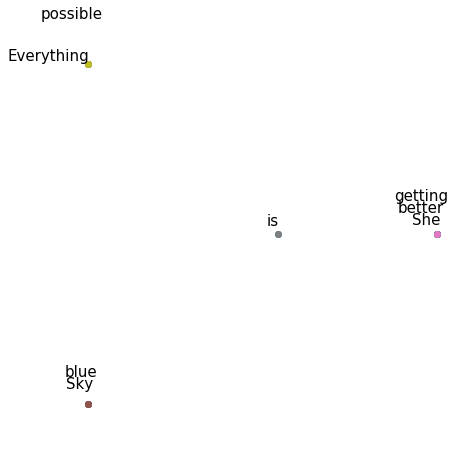

In [2]:
res = PCA().fit_transform(df)

font = {'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.scatter(res[:,0], res[:,1])
plt.axis('off')
for i, label in enumerate(df.columns):
    x, y = res[i,0], res[i,1]
    plt.scatter(x, y)
    annot = {'has': (1, 50), 'is': (1, 5)}
    plt.annotate(label, xy=(x, y),
                 xytext=annot.get(label,(1+i*2, 6*i)), 
                 textcoords='offset points',
                   ha='right', va='bottom', )

# word2vec: skip gram & cbow

Models __CBOW (Continuous Bag of Words)__ and __Skip gram__ were invented in the now distant 2013,
*article*:
[*Tomas Mikolov et al.*](https://arxiv.org/pdf/1301.3781v3.pdf)

* __CBOW__ model predict missing word (focus word) using context (surrounding words).
* __skip gram__ model is reverse to _CBOW_. It predicts context based on the word in focus.

* **Context** is a fixed number of words to the left and right of the word in focus (see picture below). The length of the context is defined by the "window" parameter.

![context](pics/context.png)

Two models comparision

![architecture](pics/architecture.png)

___

There are a lot of implementations of word2vec e.g.[gensim](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/word2vec.ipynb).
And there are a lot of trained word-vectors which are already ready to use.
___


### Skip_gram

Consider a corpus with a sequence of words $ w_1, w_2, .., w_T $.

Objective function (we would like to maximize it) for _skip gram_ is defined as follow:


$$ AverageLogProbability = \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leqslant j\leqslant c, j \neq 0} log\ p (w_{t+j} | w_t) $$

* where $ c $ is a context length.
* $w_t$ -- focus word

The basic formulation for probability $ p (w_{t+j} | w_t) $ is calculated using __Softmax__ -

$$ p (w_h | w_i) = \frac{exp(s(v_i, v_h))}{ \sum^{W}_{w=1}  exp(s(v_{w}, v_{i} )) } $$

where
* $w_i$ -- input focus word
* $w_h$ -- hypothetically context word for a given focus word $w_i$
* $v_i$ and $v_h$ input-word and hypothesis-word vector representations (for $w_i$, $w_h$)
* $s(v_i, v_h) = v^{T} _{h} \cdot v_{i}$
* $W$ is the number of words in vocabulary

___

### CBOW

Predict word using context.

$$ E = -log\ p(w_h\ |\ w_{1},\ w_{2},\ \dots,\ w_{c}) $$


The **probability** is the same as in the *skip gram* model, but now $v_i$ is a sum of context-word vectors.

$$ p(w_h\ |\ w_{1},\ w_{2},\ \dots,\ w_{c})  = \frac{exp(s(v_i, v_h))}{\sum^{W}_{w=1}  exp(s(v_{w}, v_{i}))} $$


* $\ w_{1},\ w_{2},\ \dots,\ w_{c}$ -- input context words
* $w_h$ -- hypothetically focus word for a given context words
* $ v_i = \sum^{c}_{k=1} w_{k}$
* $ v_h$ = vector of hypothesis word
* $s(v_i, v_h) = v^{T} _{h} \cdot v_{i}$
* $W$ is the number of words in vocabulary

___

Lets implement __`CBOW`__ using tf framework.

And then implement __`skip gram`__ using CBOW implementation as an example.
___

In [3]:
import tensorflow as tf

Using [text8 dataset](http://mattmahoney.net/dc/textdata),

It's a 100 Mb dump of English Wiki at the time of March 3, 2006.

# Working with data

It's not so interesting to explore this code.

Truly, all the dirty work is done for you.:3

In [4]:
# WARNING! if this file "./data/text8.zip" doesn't exist
# it will be downloaded right now.

import os, urllib.request
def fetch_data(url):
    
    filename = url.split("/")[-1]
    datadir = os.path.join(os.getcwd(), "data")
    filepath = os.path.join(datadir, filename)
    
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    if not os.path.exists(filepath):
        urllib.request.urlretrieve(url, filepath)
    
    return filepath

url = "http://mattmahoney.net/dc/text8.zip"
filepath = fetch_data(url)
print ("Data at {0}.".format(filepath))

Data at /home/cerdio/OneDrive/Courses/NLP_224/deep-nlp-seminars/seminar_02/data/text8.zip.


In [5]:
# Unzip and read data

import os, zipfile

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filepath)
print("data_size = {0}".format(len(words)))

data_size = 17005207


In [ ]:
# Only N = 50000 the most frequent words is considered
# The other marked with token `UNK` (unknown)

from collections import Counter

def build_dataset(words, vocabulary_size):
    count = [[ "UNK", -1 ]]
    count.extend(Counter(words).most_common(vocabulary_size-1))
    print("Least frequent word: ", count[-1])
    word_to_index = { word: i for i, (word, _) in enumerate(count) }
    data = [word_to_index.get(word, 0) for word in words] # map unknown words to 0
    unk_count = data.count(0) # Number of unknown words
    count[0][1] = unk_count
    index_to_word= dict(zip(word_to_index.values(), word_to_index.keys()))
    
    return data, count, word_to_index, index_to_word

vocabulary_size = 50000
data, count, word_to_index, index_to_word = build_dataset(words, vocabulary_size)

# Everything you need to know about the dataset

print("data: {0}".format(data[:10]))
print("count: {0}".format(count[:10]))
print("index_to_word: {0}".format(list(index_to_word.items())[:10]))

In [ ]:
import numpy as np
from collections import deque

def generate_batch(data_index, data_size, batch_size, bag_window):
    span = 2 * bag_window + 1 # [ bag_window, target, bag_window ]
    batch = np.ndarray(shape = (batch_size, span - 1), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    
    data_buffer = deque(maxlen = span)
    
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
        
    for i in range(batch_size):
        data_list = list(data_buffer)
        labels[i, 0] = data_list.pop(bag_window)
        batch[i] = data_list
        
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print("data = {0}".format([index_to_word[each] for each in data[:16]]))
data_index, data_size, batch_size = 0, len(data), 4
for bag_window in [1, 2]:
    data_index, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
    print("bag_window = {0}".format(bag_window))
    print("batch = {0}".format([[index_to_word[index] for index in each] for each in batch]))
    print("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(4)]))

And now just take a close look at the output.

* We just want to implement _CBOW_, and therefore missed words are considered as the `labels`.

* Remember about the __window__ parameter discussed above, here it is __`bag_window`__.

* Each sample in the batch has a number of words equal to __`bag_window * 2`__
___

# CBOW architecture


In [ ]:
import math

# define constants
batch_size = 128
embedding_size = 64

# How many words to consider from each side
bag_window = 2

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    #
    # Take the vectors for the context words, which are all bag_window * 2
    train_data = tf.placeholder(tf.int32, [batch_size, bag_window * 2])
    # Label -- is a word in focus
    train_labels = tf.placeholder(tf.int32, [batch_size, 1])
    
    # Create an embedding matrix
    # and initialize it by sampling from the uniform distribution [-1, 1]
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    # Get vectors corresponding to the indices of context words
    # embed is a matrix with shape [batch_size, bag_window * 2, embedding_size]
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    
    # Sum up all the context vectors to the one vector with the same dimension
    # Here we got a matrix of such vectors with the shape [batch_size, embedding_size]
    context_sum = <your code here>
    
    # s finction from theory above
    scores = <use tf.matmul to compute scores for context_sum and embeddings>
    
    one_hot_labels = <make labels one-hot; use tf functions>
    loss_tenosor = <implement softmax loss with cross entropy>
    loss = tf.reduce_mean(<your loss here>)

    
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    # We need to normalize word embeddings for dot product to be a cosine distance 
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm

## Optional

You may use [NCE(Noise Contrastive Estimation)](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss) loss instead of softmax with cross entropy.

Just try to make some experiments.

Using NCE will accelerate training at times.

For more details see the [original article](http://papers.nips.cc/paper/5165-learning-word-embeddings-efficiently-with-noise-contrastive-estimation.pdf).

# Let's train

In [ ]:
%%time
num_steps = 50000
loss_every_nsteps = 200
from IPython.display import clear_output


with tf.Session(graph=graph) as sess:
    try:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0

        for step in range(num_steps):
            data_index, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
            feed_dict = { train_data: batch, train_labels: labels }
            _, current_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
            average_loss += current_loss
            if step % loss_every_nsteps == 0:
                if step > 0:
                    average_loss = average_loss / loss_every_nsteps
                    clear_output(True)
                    print ("step = {0}, average_loss = {1}".format(step, average_loss))
                    average_loss = 0
    except KeyboardInterrupt:
        final_embeddings = normalized_embeddings.eval()
    final_embeddings = normalized_embeddings.eval()

# Visualization

[Use projector](http://projector.tensorflow.org/)

In [ ]:
# Use these files for Projector

with open('embeddings.txt', 'w') as f:
    for n in range(vocabulary_size):
        s = '\t'.join([index_to_word[n]] + [str(num) for num in final_embeddings[n]])
        f.write(s + '\n')
with open('mentadata.txt', 'w') as f:
    for n in range(vocabulary_size):
        f.write(index_to_word[n] + '\n')

Or see TSNE here:

In [ ]:
from sklearn.manifold import TSNE

num_points = 250

tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

plt.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]

for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()

# Test similarities of our embeddings with gensim

In [ ]:
# This file for Gensim .c (.vec) format

def create_vec_file(final_emb_mtx, vocab_size, vec_size,filename):
    with open(filename, 'w') as f:
        f.write(str(vocab_size)+' '+str(vec_size) + '\n')
        for n in range(vocab_size):
            s = ' '.join([index_to_word[n]] + [str(num) for num in final_emb_mtx[n]])
            f.write(s + '\n')
            
create_vec_file(final_embeddings, vocab_size=vocabulary_size, vec_size=embedding_size, filename='simple_cbow.vec')

In [ ]:
from gensim.models import KeyedVectors

simple_cbow = KeyedVectors.load_word2vec_format('simple_cbow.vec', binary=False)

In [ ]:
# Pick a word 
find_similar_to = 'car'

# Finding out similar words [default= top 10]
for similar_word in simple_cbow.similar_by_word(find_similar_to):
    print("Word: {0}, Similarity: {1:.2f}".format(
        similar_word[0], similar_word[1]
    ))

# Task

Your task is to implement `skip-gram` model, using code above.

This approach is nicely illustrated with this figure:

![skip_gram](pics/training_data.png)
As you can see on the picture, the training set consists of pairs (`central word`, `context word`).

I.e. our model takes `central word` and should produce class in softmax, which corresponds to `context word`.

The difference between two models is not that big after all, so good luck with coding!

In [ ]:
from collections import deque
import numpy as np
import random

def generate_batch_2(data_index, data_size, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape = batch_size, dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1
    data_buffer = deque(maxlen = span)
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    
    for i in range(batch_size // num_skips):
        target, targets_to_avoid = skip_window, [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid: 
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = data_buffer[skip_window]
            labels[i * num_skips + j, 0] = data_buffer[target]
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print ("data = {0}\n".format([index_to_word[each] for each in data[:32]]))
data_index, data_size = 0, len(data)
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    data_index, batch, labels = generate_batch_2(data_index=data_index, 
                                               data_size=data_size, 
                                               batch_size=16, 
                                               num_skips=num_skips, 
                                               skip_window=skip_window)
    print ("data_index = {0}, num_skips = {1}, skip_window = {2}".format( data_index, num_skips, skip_window))
    print ("batch = {0}".format([index_to_word[each] for each in batch]))
    print ("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(16)]))

In [ ]:
< Tensorflow code for skip-gram model itself >

In [ ]:
< Tensorflow code for training of skip-gram model >

In [ ]:
< tSNE visualization of embeddings >

# fastText

Lets look at the [fastText](https://github.com/facebookresearch/fastText) library from Facebook Research.

If you're interested, this is an article about _unsupervised learning_ with fasttext:  [link](https://arxiv.org/pdf/1607.04606v1.pdf).

* It was announced in 2016 and allows you to train embeddings and solve classification tasks. It is able to work with the Out-of-vocabulary words through the n-gram training.

* The library is implemented in C ++. [Python interface](https://pypi.python.org/pypi/fasttext) exists for it, but it is not officially supported. Thus it is not recommended to use it. Instead we will use another python wrapper from Gensim.


* fastText allows you to train embeddings very quickly even for fairly large texts compared to other methods.
* fastText works better than gensim's word2vec on small corpora.
* fastText is not a standalone NLP library; it uses other libraries for preprocessing.


The approach to learning attachments from fastText is slightly different than what was discussed above.

The basis is the same as in [skip gram](#Skip_gram) and [CBOW](#CBOW), but the $s$ function in probability definition in _Softmax_ is slightly different.

Let $ G $ be the set of n-grams that can be obtained from the word $ w $ by selecting n nearest letters. And by the way, lets add special symbols "<" and ">" to the left and right to denote prefixes and suffixes.

Then the partitioning will look like this for n = 3 and w = "< where >" we get the set: "< wh", "whe", "her", "ere", "re>" + the word "where" also included in this set.

Comparing each element $ g \in G $ with its own vector $ z_g $, we obtain the scoring function $ s $, which we will substitute into the _Softmax_ expression (as in [skip gram](# Skip_gram) or [CBOW](# CBOW))

$$ s = \sum_ {g \in G_w} z_g ^ {T} \cdot v_ {c} $$

* $v_c$ -- is a vector of word to compare with

Vectors for out-of-vocabulary words could be obtained as a sum of n-gram vectors.

---

There are two ways of fastText usage.
First way --
# Training fastText just from cmd

The first thing to do fastText installation:

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText; make

Let's see how long it takes to train embbeddings on fastText for CBOW & skip gram models.

**! WARNING!: ** * a model with a weight of 800 MB approximately will be saved to the disk*

The parameters are as follows:

    **For Skipgram, CBOW**
    
    input          training file path
    output         output file path
    lr             learning rate [0.05]
    lr_update_rate change the rate of updates for the learning rate [100]
    dim            size of word vectors [100]
    ws             size of the context window [5]
    epoch          number of epochs [5]
    min_count      minimal number of word occurences [1]
    neg            number of negatives sampled [5]
    word_ngrams    max length of word ngram [1]
    loss           loss function {ns, hs, softmax} [ns]
    bucket         number of buckets [2000000]
    minn           min length of char ngram [3]
    maxn           max length of char ngram [6]
    thread         number of threads [12]
    t              sampling threshold [0.0001]
    silent         disable the log output from the C++ extension [1]


In [ ]:
# where we a going to save our model
MODELS_DIR = 'models/'
!mkdir -p {MODELS_DIR}

In [ ]:
lr = 0.05
dim = 128
ws = 5
epoch = 5
minCount = 11
corpus_file = './data/text8'
output_file = MODELS_DIR + 'text8_cbow'
FS_HOME = '~/fastText/'

In [ ]:
!unzip ./data/text8.zip -d ./data
%time !./fastText/fasttext cbow -input {corpus_file} -output {output_file} -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -verbose 1

In [ ]:
ls -lh models/

## Use Gensim
Now we could load the model. The most easiest may to do it [via Gensim package](https://radimrehurek.com/gensim/models/wrappers/fasttext.html)

In [ ]:
from __future__ import print_function
import gensim
print(gensim.__version__)

In [ ]:
from gensim.models.wrappers import FastText

model = FastText.load_fasttext_format(output_file)

## We could know quite a lot about this model

In [ ]:
print(model.__doc__)

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(model.__dict__)

*Similar approach is also works with pretrained embeddings which you may download from the internet.*

# Training fastText directly from Gensim

Obviously, this way is quite easier and appropriate when you just need to train your own embeddings.

In [ ]:
# uncomment if you would like to try it
# model = FastText.train('./fastText/fasttext', corpus_file='./data/text8')
# print(model['forests'])

# Testing vectors

In [ ]:
# Getting the tokens 
model_words = []
for word in model.wv.vocab:
    model_words.append(word)


# Printing out number of tokens available
print("Number of Tokens: {}".format(len(model_words)))

# Printing out the dimension of a word vector 
print("Dimension of a word vector: {}\n".format(
    len(model[words[0]])
))


# Pick a word 
find_similar_to = 'car'

# Finding out similar words [default= top 10]
for similar_word in model.similar_by_word(find_similar_to):
    print("Word: {0}, Similarity: {1:.2f}".format(
        similar_word[0], similar_word[1]
    ))

# TSNE

In [ ]:
import random
tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
num_points = 100

random_points = random.sample(model_words,num_points)
random_points_mtx = np.array([model[word] for word in random_points])

two_d_embeddings = tsne.fit_transform(random_points_mtx)

plt.figure(figsize=(15,15))

for i, label in enumerate(random_points):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()